In [1]:
# Rather than importing everything manually, we'll make things easy
#   and load them all in utils.py, and just import them from there.
%matplotlib inline
import utils; reload(utils)
from utils import *

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
%matplotlib inline
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import utils; reload(utils)
from utils import plots, get_batches, plot_confusion_matrix, get_data

In [3]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [4]:
path = "sample/"
# path = "data/dogscats/"
model_path = path + 'models/'
if not os.path.exists(model_path): 
    os.mkdir(model_path)

In [5]:
# batch_size=100
batch_size=4

In [6]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

In [7]:
# Use batch size of 1 since we're just doing preprocessing on the CPU
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
batches = get_batches(path+'train', shuffle=False, batch_size=1)

Found 80 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [8]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [16]:
val_data = get_data(path+'valid')
trn_data = get_data(path+'train')


Found 80 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [9]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [10]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [11]:
trn_labels.shape

(1000, 10)

In [12]:
trn_classes[:4]

array([0, 0, 0, 0], dtype=int32)

In [13]:
trn_labels[:4]

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [17]:
trn_features = model.predict(trn_data, batch_size=batch_size)
val_features = model.predict(val_data, batch_size=batch_size)

In [14]:
# 1000 inputs, since that's the saved features, and 10 outputs, for dog and cat
lm = Sequential([ Dense(10, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
lm.fit(trn_features, trn_labels, nb_epoch=3, batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 1000 samples, validate on 80 samples
Epoch 1/3
1000/1000 [==============================] - 0s - loss: 2.3076 - acc: 0.1410 - val_loss: 2.2262 - val_acc: 0.1375
Epoch 2/3
1000/1000 [==============================] - 0s - loss: 2.1486 - acc: 0.2300 - val_loss: 2.1355 - val_acc: 0.2000
Epoch 3/3
1000/1000 [==============================] - 0s - loss: 2.0737 - acc: 0.2590 - val_loss: 2.1144 - val_acc: 0.2500


In [19]:
# We want both the classes...
preds = lm.predict_classes(val_features, batch_size=batch_size)
# ...and the probabilities of being a cat
probs = lm.predict_proba(val_features, batch_size=batch_size)[:,0]
probs[:8]

 4/80 [>.............................] - ETA: 0s

array([ 0.3122,  0.0119,  0.1533,  0.1745,  0.1849,  0.42  ,  0.1726,  0.1612], dtype=float32)

In [20]:
preds[:8]

array([0, 1, 1, 1, 0, 0, 1, 1])

In [21]:
filenames = val_batches.filenames

In [22]:
# Number of images to view for each visualization task
n_view = 4

In [23]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

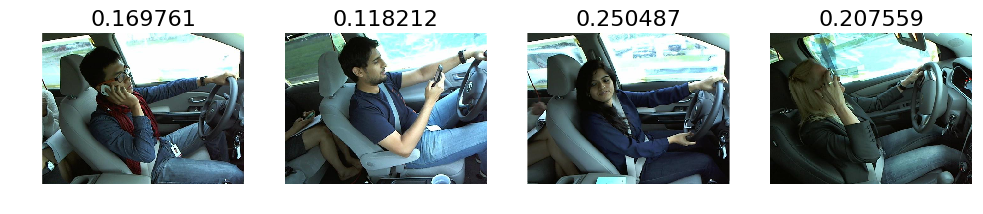

In [24]:
#1. A few correct labels at random
correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

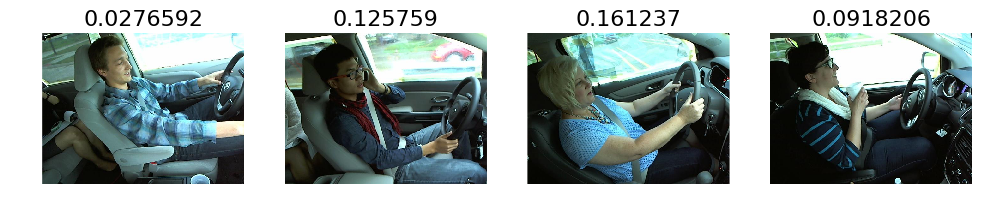

In [25]:
#2. A few incorrect labels at random
incorrect = np.where(preds!=val_labels[:,1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

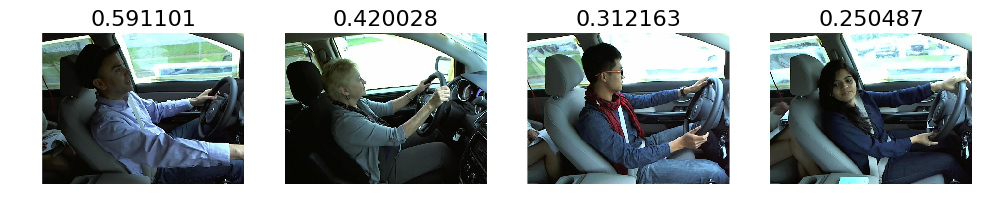

In [26]:

#3. The images we most confident were cats, and are actually cats
correct_cats = np.where((preds==0) & (preds==val_labels[:,1]))[0]
most_correct_cats = np.argsort(probs[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], probs[correct_cats][most_correct_cats])

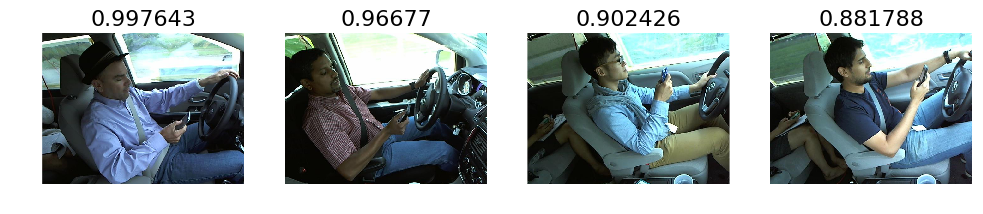

In [27]:
# as above, but dogs
correct_dogs = np.where((preds==1) & (preds==val_labels[:,1]))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], 1-probs[correct_dogs][most_correct_dogs])

In [28]:
#3. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((preds==0) & (preds!=val_labels[:,1]))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats])[::-1][:n_view]
if len(most_incorrect_cats):
    plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])
else:
    print('No incorrect cats!')

No incorrect cats!


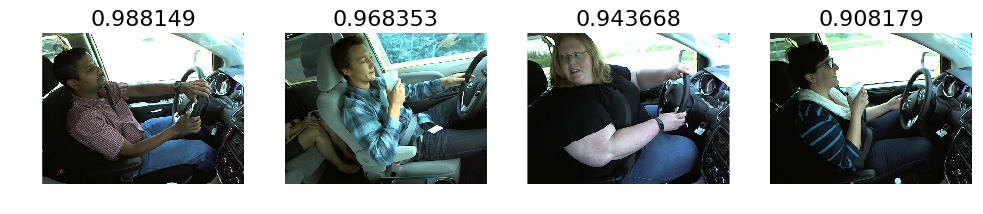

In [29]:
#3. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((preds==1) & (preds!=val_labels[:,1]))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[:n_view]
if len(most_incorrect_dogs):
    plots_idx(incorrect_dogs[most_incorrect_dogs], 1-probs[incorrect_dogs][most_incorrect_dogs])
else:
    print('No incorrect dogs!')

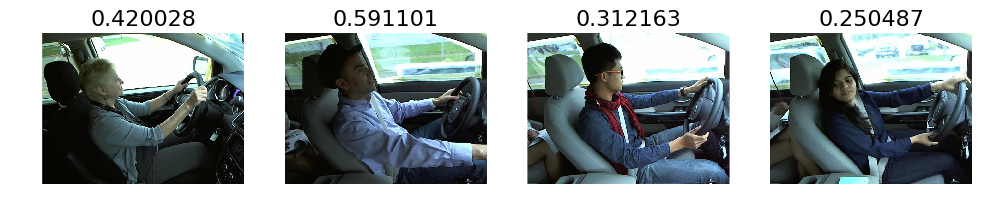

In [30]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])

In [31]:
cm = confusion_matrix(val_classes, preds)

[[3 5 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 1 0 0]
 [1 2 2 0 2 1 0 0 0 0]
 [0 7 0 1 0 0 0 0 0 0]
 [0 4 0 1 2 1 0 0 0 0]
 [2 3 1 1 0 1 0 0 0 0]
 [1 5 2 0 0 0 0 0 0 0]
 [1 4 0 0 0 0 0 3 0 0]
 [1 4 0 0 0 1 0 1 0 1]
 [2 4 1 0 0 0 0 0 0 1]]


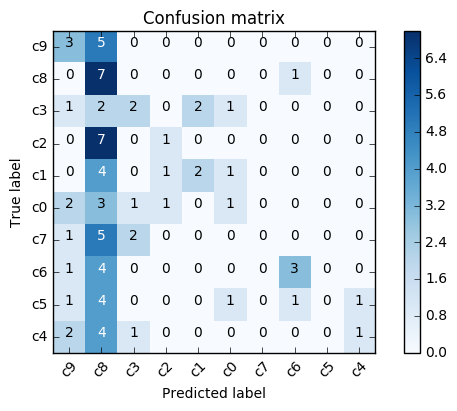

In [32]:
plot_confusion_matrix(cm, val_batches.class_indices)

In [33]:
model.pop()
for layer in model.layers: layer.trainable=False

In [34]:
model.add(Dense(10, activation='softmax'))

In [35]:
gen=image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

In [39]:

def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.N)

In [40]:
opt = RMSprop(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/2
1000/1000 [==============================] - 29s - loss: 14.5002 - acc: 0.0980 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/2
1000/1000 [==============================] - 29s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000


In [42]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________